### Model inspired by:

- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

### Implementation aspects:

- This implementation is more like pseudo steady-state finite difference method rather than fully dynamic FEM

In [1]:
import numpy as np
import inspect
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys

In [3]:
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [4]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

### Modelling data:

In [5]:
mp = 96       #  (submerged pipe weight) [kg/m]
N = 20        # number of modelling nodes

In [6]:
mi = [mp for i in range(N)]

In [7]:
# Vessel:

# L - the hull length
# Xg - x-center of gravity

L = 84.6 # [m]
B = 12
H = 13
Xg = L/2 # [m]
mn = 27_162_500 #123_000_000   # mass of the vessel, [kg]

In [8]:
lx, ly, lz = L/2, B/2, H/2

In [9]:
vessel_mass = mn/L # mass over length of the vessel

In [10]:
diag_Jrho0 = 1e2*np.array([1, 1, 2]) # [m^4] 
Jrho0 = np.diag(diag_Jrho0)

In [11]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [12]:
Ar=np.pi*((d0/2)**2-(dI/2)**2)   

In [13]:
E = 210e9

In [14]:
h = 100 # water depth

In [15]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [16]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [17]:
# Underwater current: 
dv1_curr = np.zeros(N)
dv2_curr = np.zeros(N)
dv3_curr = np.zeros(N)

In [18]:
# Constants: 

In [19]:
diag_DT = 1.5*np.array([1, 1, 1])
DT=np.diag(diag_DT)

In [20]:
diag_CT = 1e9*np.array([1, 1, 1 ])  
CT=np.diag(diag_CT)

In [21]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [22]:
diag_DR = 1.5*np.array([1, 1, 1])
DR=np.diag(diag_DR)

In [23]:
# for testing:

In [24]:
φ = np.random.rand(N)
θ = np.random.rand(N)
ψ = np.random.rand(N)

In [25]:
φ

array([0.28265052, 0.46379931, 0.13023964, 0.85749681, 0.78796179,
       0.38607397, 0.05262089, 0.01395793, 0.98992701, 0.96592565,
       0.6717559 , 0.1097814 , 0.26726068, 0.62800332, 0.92931519,
       0.19486656, 0.06772384, 0.66670292, 0.53342527, 0.32853082])

In [26]:
dφ = np.random.rand(N)
dθ = np.random.rand(N)
dψ = np.random.rand(N)

In [27]:
ddφ = np.random.rand(N)
ddθ = np.random.rand(N)
ddψ = np.random.rand(N)

In [28]:
x = np.random.rand(N)
y = np.random.rand(N)
z = np.random.rand(N)

In [29]:
dx = np.random.rand(N)
dy = np.random.rand(N)
dz = np.random.rand(N)

### Main functions:

In [30]:
def Π0(φθψ):
    φ0,θ0,ψ0=φθψ
    return np.array([[np.cos(θ0),0,np.cos(φ0)*np.sin(θ0)],
                  [0,1,-np.sin(φ0)],
                  [-np.sin(θ0),0,np.cos(φ0)*np.cos(θ0)]])

In [31]:
def Π(φ,θ,ψ):
    φθψ=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Π0, 1, φθψ)

In [32]:
Π(φ,θ,ψ)

array([[[ 0.98448578,  0.        ,  0.16850188],
        [ 0.        ,  1.        , -0.27890197],
        [-0.17546438,  0.        ,  0.94542097]],

       [[ 0.9173516 ,  0.        ,  0.35602471],
        [ 0.        ,  1.        , -0.44734928],
        [-0.39807793,  0.        ,  0.82044197]],

       [[ 0.83119892,  0.        ,  0.55126648],
        [ 0.        ,  1.        , -0.12987176],
        [-0.55597514,  0.        ,  0.82415933]],

       [[ 0.98516367,  0.        ,  0.11229485],
        [ 0.        ,  1.        , -0.75620701],
        [-0.17161743,  0.        ,  0.64462456]],

       [[ 0.80398018,  0.        ,  0.41940601],
        [ 0.        ,  1.        , -0.70891721],
        [-0.5946561 ,  0.        ,  0.56704055]],

       [[ 0.60727902,  0.        ,  0.73600995],
        [ 0.        ,  1.        , -0.37655428],
        [-0.79448864,  0.        ,  0.56257998]],

       [[ 0.97892845,  0.        ,  0.20392092],
        [ 0.        ,  1.        , -0.05259661],
        

In [33]:
def w_e(φ,θ,ψ,dφ,dθ,dψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((dφ,dθ,dψ), axis=1))

In [34]:
w_e(φ,θ,ψ,dφ,dθ,dψ)

array([[ 0.48294497,  0.60657074,  0.56571514],
       [ 1.15182446, -0.08518364,  0.44987093],
       [ 0.09755966,  0.56930081,  0.09087985],
       [ 0.19890153,  0.01099258,  0.22936778],
       [ 0.35592202,  0.06946451, -0.12307607],
       [ 0.71940774,  0.17216315, -0.70594642],
       [ 0.24801469,  0.7421562 ,  0.43392274],
       [ 0.51057343,  0.23344074,  0.71828116],
       [ 0.89543151, -0.60429191, -0.10684899],
       [ 0.54176576,  0.35762897,  0.13226095],
       [ 0.72480118, -0.32072492,  0.40486438],
       [ 0.66231186,  0.32892824,  0.58633023],
       [ 0.89445615,  0.11733819,  0.00757512],
       [ 0.62071782,  0.43197089, -0.15541833],
       [ 0.46704055, -0.05216721,  0.24516624],
       [ 1.03903068,  0.67272001, -0.36647185],
       [ 0.53253984,  0.07391686,  0.22801551],
       [ 1.11545385,  0.31922452, -0.00186536],
       [ 0.46190528,  0.47059107,  0.26808071],
       [ 1.32853751, -0.2713647 , -0.0999092 ]])

In [35]:
def dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ):
    return (np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((ddφ,ddθ,ddψ), axis=1))+
        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1)))

In [36]:
dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ)

array([[ 0.92559994,  0.82946426,  0.24728518],
       [ 1.69656065, -0.49483212,  0.48382067],
       [ 1.17744707,  0.9719808 ,  0.03511473],
       [ 0.56756697,  0.73611169,  0.33777156],
       [ 0.44677954,  0.4758439 ,  0.16410625],
       [ 1.93423861, -0.03182148, -0.63760927],
       [ 1.1712368 ,  0.7975812 ,  0.42853162],
       [ 1.46293402,  0.84809962,  0.93837695],
       [ 1.53006039, -0.0161027 ,  0.04471411],
       [ 1.35453942,  1.0429741 ,  0.10502696],
       [ 1.48710647, -0.16505192,  0.72037959],
       [ 1.60603329,  0.40869979,  1.14618225],
       [ 1.21700913,  0.16173506,  0.24132515],
       [ 1.13288282,  0.20732915, -0.01518901],
       [ 1.27804756,  0.42695404,  0.08037995],
       [ 1.75719005,  0.86679957,  0.06336314],
       [ 0.90044677,  0.22696432,  0.86590029],
       [ 2.1033564 ,  0.25094969, -0.31094571],
       [ 0.88710431,  1.03639029,  0.65939119],
       [ 1.13319398, -0.11945723,  0.52939557]])

In [37]:
def phi(x,y,z): return np.stack((x,y,z), axis=1) 
def theta(φ,θ,ψ): return np.stack((φ,θ,ψ), axis=1) 

In [38]:
phi(x,y,z)

array([[0.93372074, 0.88820974, 0.9645363 ],
       [0.43512263, 0.54984851, 0.92905935],
       [0.23370943, 0.7447853 , 0.99300944],
       [0.79073305, 0.61323024, 0.81240944],
       [0.24654362, 0.467547  , 0.30591597],
       [0.04607882, 0.16387844, 0.22608736],
       [0.81334076, 0.49082653, 0.61499811],
       [0.71464722, 0.15188947, 0.41265728],
       [0.2036324 , 0.11267123, 0.48496986],
       [0.8258654 , 0.55556286, 0.64679623],
       [0.51234254, 0.85740308, 0.01370851],
       [0.91211164, 0.35841073, 0.53702516],
       [0.01095484, 0.16899587, 0.7763081 ],
       [0.76563018, 0.17025538, 0.74852509],
       [0.84135159, 0.51724983, 0.87498602],
       [0.65502866, 0.08320339, 0.24595432],
       [0.48699414, 0.86932956, 0.81941544],
       [0.5930771 , 0.03402474, 0.55597582],
       [0.26569669, 0.99589577, 0.54356578],
       [0.54270891, 0.86660952, 0.82288097]])

In [39]:
theta(φ,θ,ψ)

array([[0.28265052, 0.17637745, 0.09864589],
       [0.46379931, 0.40942065, 0.96248686],
       [0.13023964, 0.58953568, 0.81649012],
       [0.85749681, 0.17247122, 0.4219863 ],
       [0.78796179, 0.63683783, 0.83976127],
       [0.38607397, 0.91816506, 0.08685733],
       [0.05262089, 0.20565006, 0.75465322],
       [0.01395793, 0.33910321, 0.61324458],
       [0.98992701, 0.73904926, 0.28883928],
       [0.96592565, 0.10950057, 0.26174729],
       [0.6717559 , 0.41361914, 0.83979228],
       [0.1097814 , 0.20287683, 0.01222858],
       [0.26726068, 0.07778099, 0.6358339 ],
       [0.62800332, 0.31618672, 0.0662667 ],
       [0.92931519, 0.69653951, 0.28718886],
       [0.19486656, 0.91369435, 0.45298723],
       [0.06772384, 0.4842375 , 0.54311301],
       [0.66670292, 0.66755933, 0.74037153],
       [0.53342527, 0.07895525, 0.59415297],
       [0.32853082, 0.81193667, 0.50186824]])

In [40]:
def ω(φ,θ,ψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), theta(φ,θ,ψ))

In [41]:
ω(x,y,z)

array([[ 1.03419213,  0.11287807, -0.36259086],
       [ 0.81123611,  0.15822992,  0.49093159],
       [ 0.82660845,  0.51481654,  0.55183393],
       [ 0.97549652,  0.03571352,  0.01220029],
       [ 0.35379027,  0.39288712,  0.15370973],
       [ 0.08230753,  0.15346429,  0.2153039 ],
       [ 0.91649161,  0.04397716, -0.01070718],
       [ 0.75358008, -0.11854589,  0.19997115],
       [ 0.25574124,  0.01459675,  0.44904313],
       [ 0.93292042,  0.08008049, -0.06304775],
       [ 0.34431333,  0.85068289, -0.37958658],
       [ 0.96945575, -0.06626769, -0.01214261],
       [ 0.14136023,  0.16049171,  0.76336049],
       [ 0.84599475, -0.34846611,  0.40211973],
       [ 1.01964557, -0.13509125,  0.09081326],
       [ 0.66897269, -0.06662755,  0.13993677],
       [ 0.86745419,  0.48586641,  0.09531101],
       [ 0.6084172 , -0.27671864,  0.44058669],
       [ 0.5846509 ,  0.85316541,  0.06220821],
       [ 0.88839328,  0.44162643,  0.04257702]])

In [42]:
def Ret(φ,θ,ψ):
    
    def Ret0(arr):
        φ,θ,ψ=arr
        Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

        Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

        Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


        return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )
    
    arr=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Ret0, 1, arr)

In [43]:
Ret(φ,θ,ψ)

array([[[ 0.98451929, -0.0482586 ,  0.16850188],
        [ 0.09457801,  0.95565093, -0.27890197],
        [-0.14756956,  0.29052094,  0.94542097]],

       [[ 0.67038408, -0.65102349,  0.35602471],
        [ 0.73392495,  0.51110937, -0.44734928],
        [ 0.10926732,  0.56119126,  0.82044197]],

       [[ 0.62181059, -0.55628847,  0.55126648],
        [ 0.72257491,  0.67898367, -0.12987176],
        [-0.30205477,  0.47908696,  0.82415933]],

       [[ 0.95189609, -0.28510296,  0.11229485],
        [ 0.26799711,  0.59693258, -0.75620701],
        [ 0.14856441,  0.7499252 ,  0.64462456]],

       [[ 0.85061581, -0.31709832,  0.41940601],
        [ 0.52507821,  0.47088136, -0.70891721],
        [ 0.02730599,  0.82323715,  0.56704055]],

       [[ 0.63094202,  0.24535998,  0.73600995],
        [ 0.08036302,  0.9229023 , -0.37655428],
        [-0.77165663,  0.2967319 ,  0.56257998]],

       [[ 0.7205159 , -0.66277681,  0.20392092],
        [ 0.68408788,  0.72750077, -0.05259661],
        

In [44]:
def d_s(func, a, b, c, φ, θ, ψ): 
    
    sig = inspect.signature(func)
    num_args = len(sig.parameters)
    
    if num_args==3:
        fu = func(a, b, c)
    else:
        fu = func(a, b, c, φ, θ, ψ)

    def S(arr):
        a1, a2, a3 = arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    S0 = np.apply_along_axis(S, 1, ω(φ,θ,ψ))

    
    return np.einsum('ijk,ik->ij',S0, fu).T

In [45]:
d_s(phi,x,y,z,φ, θ, ψ).T

array([[ 0.10480034, -0.24365705,  0.12292363],
       [-0.35232529, -0.45037906,  0.43156012],
       [ 0.03286728, -0.41411108,  0.30285961],
       [-0.19569866, -0.62606852,  0.6630518 ],
       [ 0.00914144, -0.29966659,  0.4506285 ],
       [ 0.24244987, -0.07934272,  0.00809757],
       [-0.25475905,  0.46496374, -0.03416371],
       [ 0.04927403,  0.32033626, -0.20324191],
       [ 0.30324295, -0.51853912, -0.00685743],
       [-0.09198796, -0.59652392,  0.62983701],
       [-0.28606965,  0.15799421,  0.80978336],
       [ 0.11189126, -0.06837774, -0.14440665],
       [-0.16978942, -0.23737155,  0.05406981],
       [ 0.23210028, -0.56974196, -0.10781382],
       [ 0.64833923, -1.11092296,  0.03330736],
       [ 0.19340436, -0.03907021, -0.50185995],
       [-0.02282075, -0.03762402,  0.05347867],
       [ 0.11509261, -0.46514865, -0.09430667],
       [-0.58732398, -0.18665217,  0.6290612 ],
       [ 0.45820592, -0.42164329,  0.14185242]])

In [46]:
d_s(theta, φ, θ, ψ, φ, θ, ψ).T

array([[ 6.98307411e-03, -1.67469909e-02,  9.93474729e-03],
       [-2.68068226e-01, -4.58705507e-01,  3.24298836e-01],
       [ 4.07493982e-02, -3.77684407e-01,  2.66201934e-01],
       [-8.34141204e-02, -2.69411772e-01,  2.79613626e-01],
       [ 3.00161718e-02, -8.21759922e-01,  5.95021737e-01],
       [ 3.13673208e-01, -1.25472516e-01, -6.78881386e-02],
       [-2.42635831e-02, -1.16752502e-01,  3.35080144e-02],
       [ 8.18681910e-03, -1.25149536e-01,  6.90170611e-02],
       [ 5.49940933e-01, -7.86285417e-01,  1.27068140e-01],
       [-3.23367517e-02, -2.14621849e-01,  2.09118161e-01],
       [-2.28848416e-01, -5.15476727e-01,  4.36942943e-01],
       [ 4.53668673e-03, -2.46618884e-03,  1.87165139e-04],
       [-1.03252439e-01, -4.18636176e-02,  4.85213359e-02],
       [ 6.40013203e-02, -1.31284360e-01,  1.98792095e-02],
       [ 4.57428496e-01, -6.67957571e-01,  1.39850795e-01],
       [ 2.67100488e-01, -1.90479536e-01,  2.69303668e-01],
       [ 2.60756964e-02, -1.39214289e-01

In [47]:
def ne(x, y, z, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp',RET, CT), np.transpose(RET,(0,2,1))) 
    B = d_s(phi, x, y, z, φ, θ, ψ).T
    t0 = np.diff(phi(x,y,z),axis=0)
    t1 = np.insert(t0, 0, [0,0,0], axis=0)
    return np.einsum('ijk,ik->ij', A, B - t1 )

In [48]:
ne(x, y, z, φ, θ, ψ)

array([[ 1.04800343e+08, -2.43657045e+08,  1.22923635e+08],
       [ 1.46272814e+08, -1.12017836e+08,  4.67037080e+08],
       [ 2.34280483e+08, -6.09047865e+08,  2.38909511e+08],
       [-7.52722283e+08, -4.94513455e+08,  8.43651806e+08],
       [ 5.53330866e+08, -1.53983350e+08,  9.57121972e+08],
       [ 4.42914663e+08,  2.24325829e+08,  8.79261764e+07],
       [-1.02202099e+09,  1.38015658e+08, -4.23074456e+08],
       [ 1.47967577e+08,  6.59273322e+08, -9.01083051e+05],
       [ 8.14257775e+08, -4.79320891e+08, -7.91700099e+07],
       [-7.14220961e+08, -1.03941554e+09,  4.68010641e+08],
       [ 2.74532074e+07, -1.43846004e+08,  1.44287107e+09],
       [-2.87877834e+08,  4.30614610e+08, -6.67723297e+08],
       [ 7.31367374e+08, -4.79566952e+07, -1.85213128e+08],
       [-5.22575058e+08, -5.71001469e+08, -8.00308076e+07],
       [ 5.72617825e+08, -1.45791741e+09, -9.31535731e+07],
       [ 3.79727287e+08,  3.94976229e+08,  1.27171749e+08],
       [ 1.45213772e+08, -8.23750196e+08

In [49]:
d_s(ne, x, y, z, φ, θ, ψ).T

array([[ 2.89387378e+07, -3.16723403e+07, -8.74524946e+07],
       [ 5.78983593e+07, -2.70247696e+08, -8.29516966e+07],
       [ 4.81250034e+08,  7.29009090e+06, -4.53340998e+08],
       [-6.19656171e+07, -8.46659647e+08, -5.51563436e+08],
       [ 4.09086449e+07, -9.39229248e+08, -1.74754824e+08],
       [ 1.35701257e+08, -1.40448791e+08, -3.25247683e+08],
       [-1.70547650e+08, -6.56092281e+08,  1.97961066e+08],
       [-3.78472211e+08,  8.50732662e+07,  9.42407489e+07],
       [-3.02852948e+08, -3.81179300e+08, -8.07037493e+08],
       [-5.45304265e+06, -4.87247647e+08, -1.09046122e+09],
       [-1.09580642e+08, -1.25961399e+09, -1.23491351e+08],
       [-1.30172709e+08,  7.63758905e+07,  1.05376602e+08],
       [ 4.50196018e+07,  4.90150749e+08,  5.08595581e+07],
       [-1.04589592e+08,  1.24514993e+08, -2.05450033e+08],
       [-7.20505251e+08, -1.89248183e+08, -1.46710345e+09],
       [ 5.87618196e+07, -1.53925322e+07, -1.27652424e+08],
       [ 1.36390740e+08,  2.27397979e+08

In [50]:
def me(a, b, c, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp', RET, CR), np.transpose(RET,(0,2,1))) 
    return np.einsum('ijk,ik->ij', A, ω(φ,θ,ψ))

In [51]:
me(φ, θ, ψ, φ, θ, ψ)

array([[ 2.94887433e+10,  1.48864913e+10,  4.36667924e+09],
       [ 7.68136149e+10, -2.11471486e+09,  6.05036341e+10],
       [ 5.58358682e+10,  4.83496677e+10,  6.00507942e+10],
       [ 8.92161592e+10, -1.46637779e+10,  1.24861335e+10],
       [ 9.85706583e+10,  4.15166111e+09,  7.61240919e+08],
       [ 2.98382479e+10,  8.85458561e+10, -2.57867193e+10],
       [ 2.05401662e+10,  1.65957863e+10,  7.26983577e+10],
       [ 2.17133803e+10,  3.30543863e+10,  5.73623034e+10],
       [ 8.38428108e+10,  4.97583686e+10, -5.49651075e+10],
       [ 9.76406494e+10, -1.05806381e+10,  4.23944685e+09],
       [ 8.79306419e+10, -1.09035112e+10,  3.31903331e+10],
       [ 1.09978969e+10,  2.01537054e+10, -1.02139529e+09],
       [ 3.14104563e+10, -9.01366089e+09,  5.90639501e+10],
       [ 6.13545800e+10,  2.77253034e+10, -1.44309275e+10],
       [ 8.23099518e+10,  4.66440824e+10, -4.64398474e+10],
       [ 4.70900941e+10,  8.25979889e+10,  1.17170310e+10],
       [ 3.12195427e+10,  4.47483912e+10

In [52]:
d_s(me, φ, θ, ψ, φ, θ, ψ).T

array([[-1.19209290e-07,  1.58041311e-07,  0.00000000e+00],
       [ 5.00679016e-06, -2.59353762e-06, -6.43730164e-06],
       [-3.81469727e-06,  6.95779251e-06, -3.81469727e-06],
       [-4.76837158e-07, -2.47313929e-06,  0.00000000e+00],
       [-1.11758709e-08, -2.02856688e-07,  2.38418579e-06],
       [ 3.81469727e-06, -3.21947782e-07,  7.62939453e-06],
       [ 1.90734863e-06,  2.81334512e-07,  0.00000000e+00],
       [-7.62939453e-06,  3.89320336e-06,  0.00000000e+00],
       [ 7.62939453e-06, -7.82391241e-06,  7.62939453e-06],
       [ 2.38418579e-07,  1.81425870e-06,  0.00000000e+00],
       [ 1.43051147e-06,  1.30090704e-06, -3.81469727e-06],
       [-5.96046448e-08,  3.34461798e-08,  4.76837158e-07],
       [ 0.00000000e+00, -2.02225352e-06,  0.00000000e+00],
       [ 0.00000000e+00, -9.64570428e-07,  0.00000000e+00],
       [-3.81469727e-06, -2.30706975e-06, -7.62939453e-06],
       [-3.81469727e-06,  2.79266071e-06, -7.62939453e-06],
       [ 0.00000000e+00,  2.50949549e-06

In [53]:
def fD(dx,dy,dz): 
    
    A=np.vstack([np.abs(dx-dv1_curr)*dx-(dv1_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dy-dv2_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dz-dv3_curr)])
    
    return 1/2*d0*qw*np.dot(DT, A)*9.81

In [54]:
fD(dx,dy,dz).T

array([[1201.46405877,  492.97286775,  255.17242349],
       [1784.06725452,  364.17990309, 1051.23808198],
       [ 189.06374295,  288.14871461, 2305.09330855],
       [1318.36670041, 1321.24793782,  155.17669908],
       [ 382.1249687 , 4271.64785267,  615.54917793],
       [2618.00586954,  223.73341793,  991.27714256],
       [3769.97659925, 2400.84937864, 2092.22754065],
       [  37.83820596,  572.50354218, 5396.3396484 ],
       [  39.67429835, 1106.21847949, 1731.23744081],
       [ 257.18046015, 1132.81889822, 3830.9078818 ],
       [2155.13774913,  191.00520904,   77.45710051],
       [1882.27392875, 5980.52224503, 5824.84283537],
       [2662.28351942, 3749.54088921, 2887.79588519],
       [ 666.82763301, 1364.77273567, 4991.75425348],
       [  27.41292739, 1952.04369853, 3446.48581483],
       [1114.37893964, 1022.66571289,  326.39547227],
       [1000.5890745 , 5316.91207742,  921.64293145],
       [1130.85427709, 4441.56587609, 6543.54093101],
       [3011.68331774,  572.

In [55]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(N)])

In [56]:
def sigma(x,y,z):
    e3 = np.array([[0,0,1] for x in range(N)])
    
    k = phi(x,y,z)*e3+d0/2
    
    fg_e2 = np.linalg.norm(fg_e, ord=2)
    k0=np.zeros(k.shape)
    
    for i in range(k.shape[0]):
        for j in range(k.shape[1]):
            if k[i][j]<0:
                k0[i][j]=0
            elif 0<=k[i][j]<=d0/20:
                k0[i][j]=(fg_e2*10*k[i][j]**2)/((d0/8-d0/40)*d0)
            else:
                k0[i][j]=(fg_e2*(k[i][j]-d0/40))/(d0/8-d0/40)
                
    return k0         

In [57]:
sigma(x,y,z)

array([[ 2722.55397294,  2722.55397294,  9987.23934499],
       [ 2722.55397294,  2722.55397294,  9720.03434105],
       [ 2722.55397294,  2722.55397294, 10201.69307486],
       [ 2722.55397294,  2722.55397294,  8841.45170073],
       [ 2722.55397294,  2722.55397294,  5026.64895306],
       [ 2722.55397294,  2722.55397294,  4425.39662373],
       [ 2722.55397294,  2722.55397294,  7354.59088399],
       [ 2722.55397294,  2722.55397294,  5830.60213249],
       [ 2722.55397294,  2722.55397294,  6375.24533968],
       [ 2722.55397294,  2722.55397294,  7594.08768303],
       [ 2722.55397294,  2722.55397294,  2825.80361965],
       [ 2722.55397294,  2722.55397294,  6767.31497824],
       [ 2722.55397294,  2722.55397294,  8569.54392076],
       [ 2722.55397294,  2722.55397294,  8360.28811543],
       [ 2722.55397294,  2722.55397294,  9312.76535588],
       [ 2722.55397294,  2722.55397294,  4575.03041105],
       [ 2722.55397294,  2722.55397294,  8894.21938217],
       [ 2722.55397294,  2722.5

In [58]:
def ne_hat(x,y,z,dx,dy,dz):
    return -fg_e.T - fD(dx,dy,dz) #- sigma(x,y,z).T

In [59]:
ne_hat(x,y,z,dx,dy,dz).T

array([[-1201.46405877,  -492.97286775,  -383.33696572],
       [-1784.06725452,  -364.17990309, -1179.40262421],
       [ -189.06374295,  -288.14871461, -2433.25785078],
       [-1318.36670041, -1321.24793782,  -283.34124131],
       [ -382.1249687 , -4271.64785267,  -743.71372016],
       [-2618.00586954,  -223.73341793, -1119.44168479],
       [-3769.97659925, -2400.84937864, -2220.39208288],
       [  -37.83820596,  -572.50354218, -5524.50419063],
       [  -39.67429835, -1106.21847949, -1859.40198304],
       [ -257.18046015, -1132.81889822, -3959.07242403],
       [-2155.13774913,  -191.00520904,  -205.62164274],
       [-1882.27392875, -5980.52224503, -5953.0073776 ],
       [-2662.28351942, -3749.54088921, -3015.96042742],
       [ -666.82763301, -1364.77273567, -5119.91879571],
       [  -27.41292739, -1952.04369853, -3574.65035706],
       [-1114.37893964, -1022.66571289,  -454.5600145 ],
       [-1000.5890745 , -5316.91207742, -1049.80747368],
       [-1130.85427709, -4441.5

In [60]:
def Jrho(Ret,Jrho0): 
    ans=  Ret @ Jrho0 @ Ret
    return ans

In [61]:
RET = Ret(φ, θ, ψ)

In [62]:
Jrho(RET,Jrho0)

array([[[ 9.14982527e+01,  4.27675932e-01,  4.97963184e+01],
        [ 2.65812323e+01,  7.46650763e+01, -7.77955894e+01],
        [-3.96838893e+01,  8.34087285e+01,  1.68174901e+02]],

       [[ 4.94161706e+00, -3.69584081e+01,  1.11410342e+02],
        [ 7.69366210e+01, -7.18666601e+01, -7.01397237e+01],
        [ 6.64418332e+01,  1.13654424e+02,  1.13410342e+02]],

       [[-3.48337027e+01, -1.95407679e+01,  1.32369232e+02],
        [ 1.01837807e+02, -6.53810014e+00,  9.60804826e+00],
        [-3.39527157e+01,  1.28300979e+02,  1.12974465e+02]],

       [[ 8.63065432e+01, -2.73150168e+01,  4.67265927e+01],
        [ 1.90390713e+01, -8.54275656e+01, -1.39624913e+02],
        [ 5.33932192e+01,  1.37213902e+02,  2.80665960e+01]],

       [[ 5.79950422e+01,  2.71496677e+01,  1.05719027e+02],
        [ 6.55174003e+01, -1.11198613e+02, -9.17564553e+01],
        [ 4.86458000e+01,  1.31260603e+02,  7.09152804e+00]],

       [[-7.18088204e+01,  8.18046468e+01,  1.20011718e+02],
        [ 7.06

### Static solution

In [63]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [64]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [65]:
Fx_0 = 82945396 #####??????
Fy_0 = 82945396 #####??????

In [66]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]

In [67]:
S=np.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [68]:
delta_x=horizontal_length/(N-1)

In [69]:
x0=[i*delta_x for i in range(N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(np.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

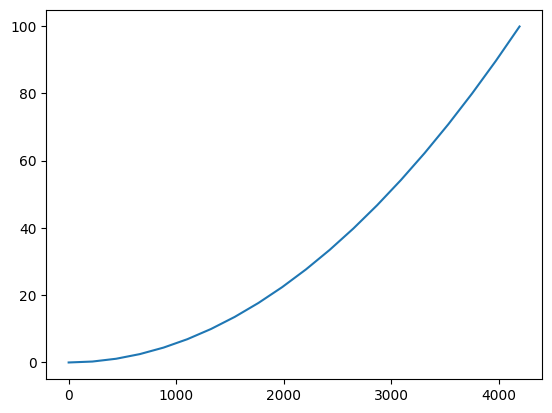

In [70]:
plt.plot(x0, z0)
plt.show()

In [71]:
q0=np.zeros(12*N)

In [72]:
for j in range(1,12):
    if j==1:
        q0[(j-1)*N:j*N]=x0
    elif j==5:
        q0[(j-1)*N:j*N]=z0

In [73]:
def static_func(Q): 
    t=0

    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    RET = Ret(φ,θ,ψ)

    η = [x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force = np.array([-Fx_0,Fy_0,0,0,0,0])

    Z0 = tau_force[:3]
#     Z0 = RET @ tau_force[:3]
    
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T


    Z = (Z1 + Z2 - Z0)


############################################################
    ddx,ddy, ddz = (Z/Ws[0]).T
############################################################
    
    C0 = np.einsum('ijk,kp->ijp', Π(φ,θ,ψ), tau_force[3:].reshape(3,1))
#     C0 = np.einsum('ijk,ikr->ijr', Π(φ,θ,ψ), RET) @ tau_force[3:]

    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)

    C = (C1.T - C0.squeeze())

    A0 = Jrho(RET,Jrho0)
    A_fin = np.einsum('ijk,ikr->ijr',A0, Π(φ,θ,ψ))

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 
    
    H = np.cross(D,np.einsum('ijk,ik->ij', A0, D))

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, C + G - L - H - np.einsum('ijk,ik->ij',A0, B)).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return ans

In [74]:
root_ = root(static_func, q0, method='df-sane')

In [75]:
root_

 message: too many function evaluations required
 success: False
     fun: [ 1.201e+02  1.201e+02 ...  0.000e+00  0.000e+00]
       x: [ 2.155e+03  2.375e+03 ...  0.000e+00  0.000e+00]
     nit: 437
    nfev: 1000
  method: df-sane

In [76]:
x0_, z0_=root_.x[:N],root_.x[4*N:5*N]

In [77]:
# q0 = root_.x                                            # start from static solution

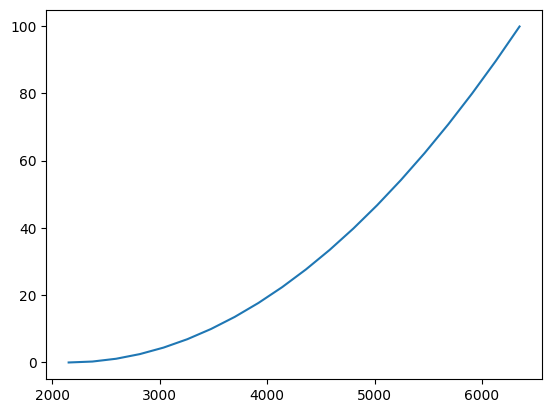

In [78]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [79]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [80]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = np.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [81]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [82]:
def FEA(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):

    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    glob_force = np.zeros(len(vessel_movement))


    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [83]:
# 10 The Space Frame Element - verification
d,f=FEA(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6)),
        bc_val=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4],
        vessel_movement=[ 0, 0, 0, 0, 0,0.0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [84]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06, -7.050e-06,  3.350e-06,  8.930e-06,  1.450e-06,
        1.750e-06,  1.140e-06, -1.230e-05,  4.280e-06,  1.418e-05,
        1.450e-06,  1.750e-06,  1.140e-06, -2.490e-06, -7.000e-08,
        8.380e-06,  1.450e-06,  1.750e-06,  1.140e-06])

In [85]:
f

array([ 2.18575158e-15, -1.86923231e-17, -3.84067778e-15,  9.71445147e-17,
        4.94078553e-17, -1.38777878e-17, -5.59719372e-16, -2.94360890e-17,
        2.29749217e-17,  3.06625927e-19,  2.51331616e-17,  5.88721780e-17,
        1.93123512e-17,  1.42708111e-17,  1.72398987e-15, -2.85416222e-17,
        6.63802780e-17, -6.09863722e-20,  2.08166817e-17,  4.64478987e-17,
        2.42861287e-17,  1.38777878e-17,  3.17637355e-20, -1.38777878e-17])

In [86]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e6, G=84e6,  
              A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
#               A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

    bc_node = list(range(6))+list(range((len(X)-6),len(X)))
    bc_val = [0]*6 + vessel_movement

    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement

    d,f=FEA(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    fors[0][0]=0
    fors[0][1]=0
    fors[0][2]=0
    return np.array(fors), np.array(mom), np.array(angle)

In [87]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [88]:
fors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.36735126e-11,  1.96143990e-10,  2.92582847e-10],
       [-1.15164767e-10,  2.21195728e-10, -3.93084152e-01],
       [-5.46174829e+02, -4.25975389e-01,  5.67951505e-10],
       [-1.63709046e-10,  1.28317572e-10, -1.53903557e-10],
       [ 1.16415322e-10, -4.57690023e-11, -2.33967512e-10],
       [ 7.27595761e-11,  5.75199888e-11, -7.59428076e-11],
       [-6.11180440e-10,  3.18803595e-11,  3.76303433e-10],
       [ 6.54836185e-10,  3.02474046e-10,  1.49839252e-10],
       [-4.65661287e-10, -3.54043239e-10, -4.60204319e-10],
       [-1.16415322e-10, -2.69584771e-10, -1.09139364e-11],
       [-1.16415322e-10, -1.67540815e-10,  3.54702934e-11],
       [-1.16415322e-10, -1.29239286e-10,  2.71938916e-10],
       [ 3.49245965e-10,  1.62247993e-11, -7.27595761e-11],
       [-2.32830644e-10, -2.60436117e-12, -2.54658516e-11],
       [ 2.34874970e-10,  6.05824628e-12,  1.03939901e-10],
       [ 1.59125998e-10, -1.10002683e-12

In [89]:
mom

array([[-3.84411608e+01,  6.81723807e+01,  7.01588596e+01],
       [-4.55671056e-10, -8.75660877e-10,  1.88974836e-10],
       [ 3.73805739e+01,  1.11813890e+03,  2.11942621e+02],
       [ 5.47174750e-10, -6.57109922e-11,  3.70761200e-11],
       [ 1.13940355e-11,  1.09309894e-10,  4.20475599e-11],
       [ 5.88428861e-10,  1.40062184e-10,  1.03302700e-10],
       [ 1.55324642e-10,  1.41369583e-10,  1.82692084e-10],
       [-1.95115035e-11, -2.60115485e-10, -7.92650834e-10],
       [-2.93946367e-10, -8.79367690e-11,  3.67798236e-10],
       [-1.48276058e-10, -1.81898940e-10, -6.48507026e-10],
       [ 3.35489858e-10, -1.59218416e-10,  1.06063425e-09],
       [ 1.96934025e-10, -7.82165444e-11,  3.87298305e-10],
       [-3.68111763e-10,  5.63318281e-11,  1.00357056e-09],
       [-3.14031467e-10,  2.60115485e-10,  7.20527638e-10],
       [ 2.72109446e-10, -3.46744855e-12, -1.53212909e-09],
       [ 3.82904868e-10, -2.47327274e-10, -4.60784321e-10],
       [ 6.22846517e-11, -1.80257089e-10

In [90]:
angle

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.01002308, -0.0075341 , -0.0048391 ],
       [ 0.02      ,  0.03      ,  0.01      ],
       [ 0.02006164, -0.04902938,  0.00016327],
       [ 0.02006164, -0.04902938,  0.00016327],
       [ 0.02006164, -0.04902938,  0.00016327],
       [ 0.02006164, -0.04902938,  0.00016327],
       [ 0.02006164, -0.04902938,  0.00016327],
       [ 0.02006164, -0.04902938,  0.00016327],
       [ 0.02006164, -0.04902938,  0.00016327],
       [ 0.02006164, -0.04902938,  0.00016327],
       [ 0.02006164, -0.04902938,  0.00016327],
       [ 0.02006164, -0.04902938,  0.00016327],
       [ 0.02006164, -0.04902938,  0.00016327],
       [ 0.02006164, -0.04902938,  0.00016327],
       [ 0.02006164, -0.04902938,  0.00016327],
       [ 0.02006164, -0.04902938,  0.00016327],
       [ 0.02006164, -0.04902938,  0.00016327],
       [ 0.02006164, -0.04902938,  0.00016327],
       [ 0.02006164, -0.04902938,  0.00016327]])

### Vessle Simulation

In [91]:
sampleTime = 0.001              # sample time [seconds]
Number = 100000                      # number of samples

In [92]:
Number*sampleTime

100.0

In [93]:
vehicle=semisub('DPcontrol',0.1,-0.1,40.0,0,0)

In [94]:
[simTime, simData] = simulate(Number, sampleTime, vehicle)

In [95]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

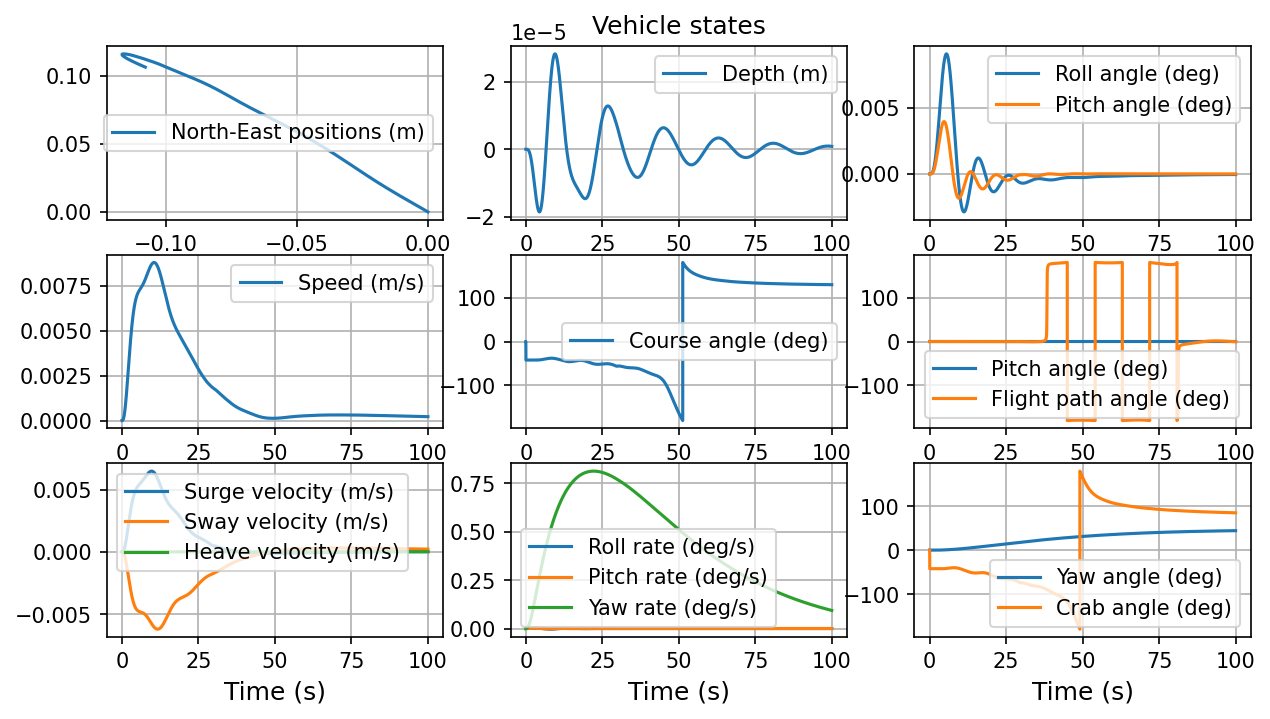

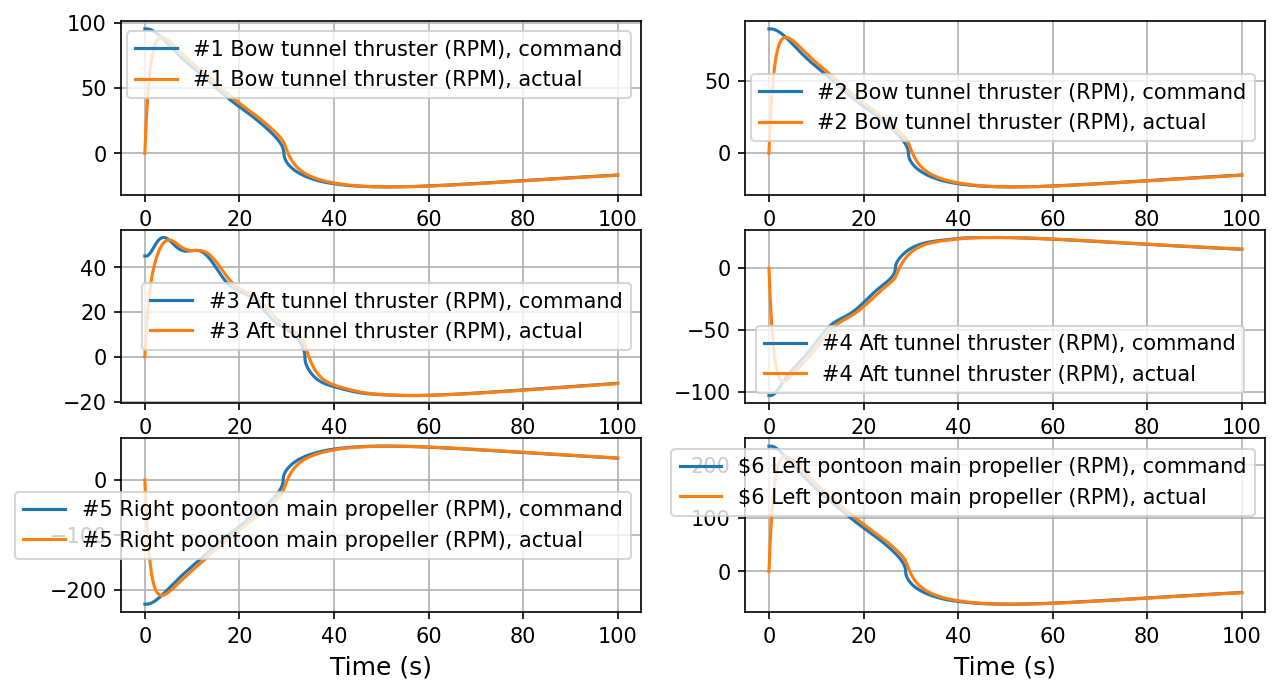

In [96]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [97]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

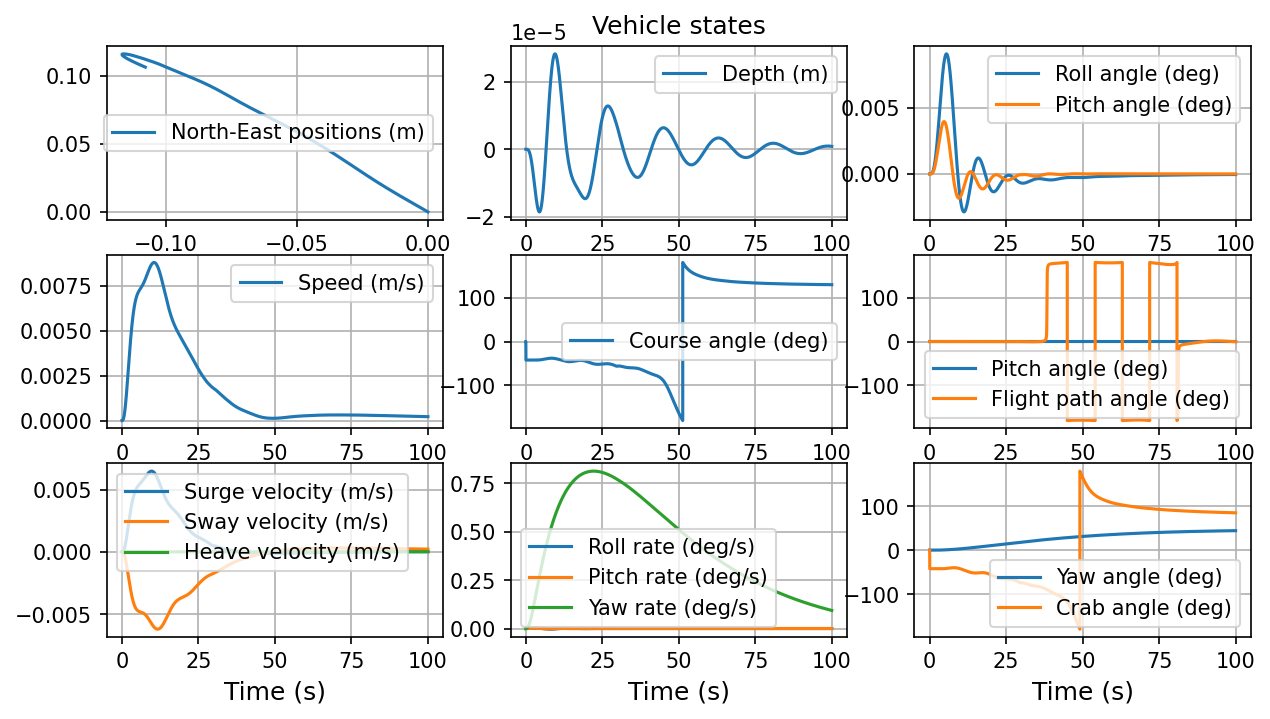

In [98]:
plotVehicleStates(simTime, simData, 3)

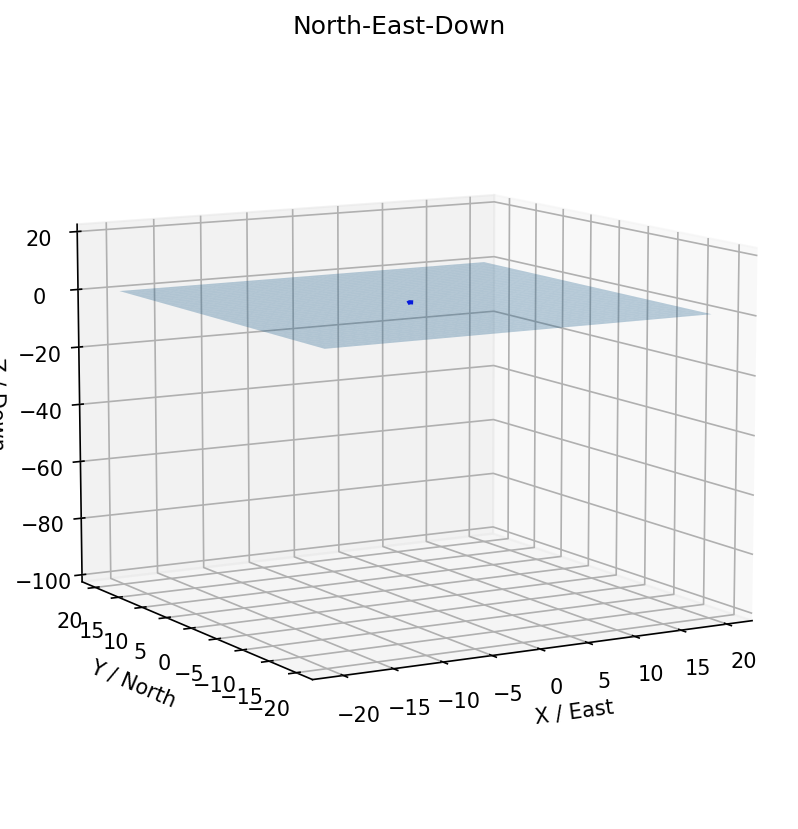

In [99]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [100]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [101]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(650)]
        self.wall_clock = datetime.now()
        self.x_ve = 0
        self.y_ve = 0
        self.z_ve = 0
        self.phi_ve = 0
        self.theta_ve = 0
        self.psi_ve = 0

In [102]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())
    return np.array(ans)  

In [103]:
V_rho=np.zeros(Jrho0.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [104]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Jrho1=inert(V_rho, Jrho0, x0)

### Dynamics

In [111]:
def dynamic_func(t, Q, coefs, T):
    
    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    idx = find_nearest(np.array(ans_t),  t)
    
    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_ve = ssa(simData[:, 5][idx])
    
    RET = Ret(φ,θ,ψ)

    vessel_movement = np.zeros(6)
    
    vessel_movement[0] = x_ve - T.x_ve
    vessel_movement[1] = y_ve - T.y_ve
    vessel_movement[2] = z_ve - T.z_ve 
    vessel_movement[3] = phi_ve - T.phi_ve
    vessel_movement[4] = theta_ve - T.theta_ve
    vessel_movement[5] = psi_ve - T.psi_ve

    fors, mom, angle = PipeForce(x, y, z, list(vessel_movement), coefs)
    
    Z0 = fors

#     Z0 = np.einsum('ijk,ik->ij', RET, fors).squeeze()  
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T

    Z = (Z1 + Z2 - Z0)


############################################################
    ddx,ddy, ddz = (Z/(M_t.reshape(-1, 1))).T
#     ddx,ddy, ddz = (Z/Ws[0]).T
############################################################
    
    C0 = np.einsum('ijk,ik->ij', Π(φ,θ,ψ), angle)
    
#     C0 = np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr', Π(φ,θ,ψ), RET), angle)
    
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0.squeeze())

    A0 = Jrho(RET,Jrho1).astype(np.float64) 
    A_fin = np.einsum('ijk,ikr->ijr', A0, Π(φ,θ,ψ))
    

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 

    H = np.cross(D, np.einsum('ijk,ik->ij', A0, D))
    

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, (C + G - L - H - np.einsum('ijk,ik->ij', A0, B))).T
#############################################


    T.x_ve=x_ve
    T.y_ve=y_ve
    T.z_ve=z_ve
    T.phi_ve = phi_ve
    T.theta_ve = theta_ve
    T.psi_ve = psi_ve

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()
    
    
    ans=np.concatenate([dx, ddx, 
                        dy, ddy, 
                        dz, ddz, 
                        dφ, ddφ, 
                        dθ, ddθ, 
                        dψ, ddψ
                       ], axis=0)

    return ans

In [112]:
# integration parameters
tspan = (0., 1)
T_ = MyTime()
coefs = [1, 1, 1, 1, 1, 1]

In [113]:
startTime1 = datetime.now()
us_=solve_ivp(dynamic_func,
             tspan,
             q0,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

Physical time:  0.3397589551887046  Iteration wall clock time:  0:00:00.880551
0:00:03.930910


### Results

In [114]:
fin=us_

In [115]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.434e-01  1.000e+00]
        y: [[ 0.000e+00  0.000e+00  0.000e+00]
            [ 2.207e+02  2.207e+02  2.207e+02]
            ...
            [ 0.000e+00  1.146e-15  1.081e-06]
            [ 0.000e+00  1.359e-15  1.509e-06]]
      sol: None
 t_events: None
 y_events: None
     nfev: 14
     njev: 0
      nlu: 0

In [116]:
t=fin.t

In [117]:
fin=fin.y.T

In [118]:
t.shape, fin.shape

((3,), (3, 240))

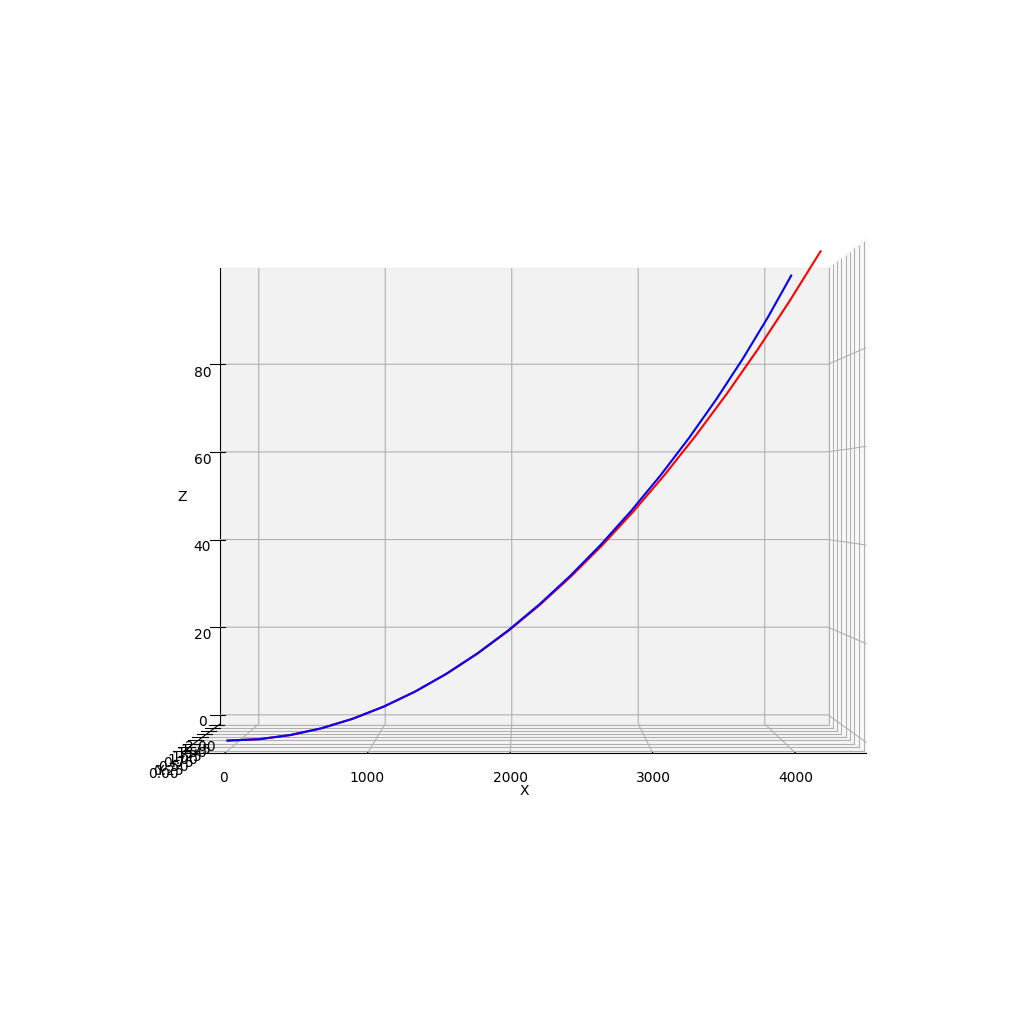

In [119]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,N)]]
Y0=fin[0,[i for i in range(2*N,3*N)]]
Z0=fin[0,[i for i in range(4*N,5*N)]]

j=-1
X=fin[j,[i for i in range(0,N)]]
Y=fin[j,[i for i in range(2*N,3*N)]]
Z=fin[j,[i for i in range(4*N,5*N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [120]:
X,Y,Z

(array([   0.        ,  220.74943519,  441.49887038,  662.24830556,
         882.99774075, 1103.74717594, 1324.49661113, 1545.24604631,
        1765.9954815 , 1986.74491669, 2207.49435188, 2428.24378706,
        2648.99322225, 2869.74265744, 3090.49209263, 3311.24152781,
        3531.990963  , 3752.74039819, 3973.48983338, 4194.23926856]),
 array([ 0.00000000e+00, -1.98455153e-13,  2.77939585e-12,  1.89152811e-12,
         1.55036059e-12,  5.19482999e-12,  1.27101687e-11,  2.61020868e-11,
         4.77888381e-11,  8.06015740e-11,  1.27784859e-10,  1.92997351e-10,
         2.80312638e-10,  3.94220247e-10,  5.39626808e-10,  7.21857382e-10,
         9.46656960e-10,  1.22019211e-09,  1.54905282e-09,  1.94025445e-09]),
 array([-2.03394718e-05,  2.76621204e-01,  1.10654756e+00,  2.48976394e+00,
         4.42627904e+00,  6.91610502e+00,  9.95925752e+00,  1.35557557e+01,
         1.77056220e+01,  2.24088827e+01,  2.76655672e+01,  3.34757086e+01,
         3.98393433e+01,  4.67565114e+01,  5.422

In [121]:
X0,Y0,Z0

(array([   0.        ,  220.74943519,  441.49887038,  662.24830556,
         882.99774075, 1103.74717594, 1324.49661113, 1545.24604631,
        1765.9954815 , 1986.74491669, 2207.49435188, 2428.24378706,
        2648.99322225, 2869.74265744, 3090.49209263, 3311.24152781,
        3531.990963  , 3752.74039819, 3973.48983338, 4194.23926856]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([ 0.        ,  0.27664154,  1.10656789,  2.48978426,  4.42629935,
         6.91612533,  9.95927782, 13.55577595, 17.70564231, 22.40890298,
        27.66558749, 33.47572887, 39.83936361, 46.7565317 , 54.22727659,
        62.25164521, 70.82968796, 79.96145874, 89.64701491, 99.88641731]))

In [122]:
us=fin.T

In [123]:
us.shape

(240, 3)

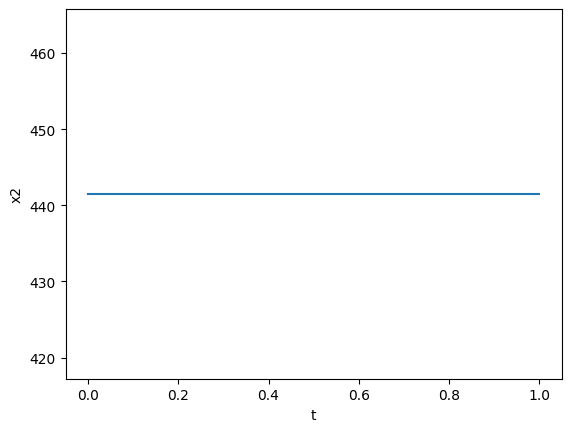

In [124]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

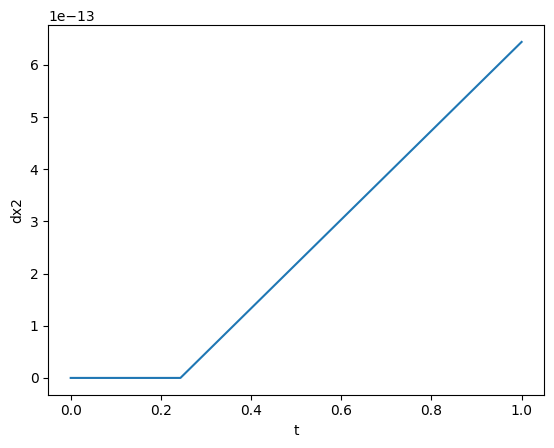

In [125]:
plt.plot(t,us.T[:,N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

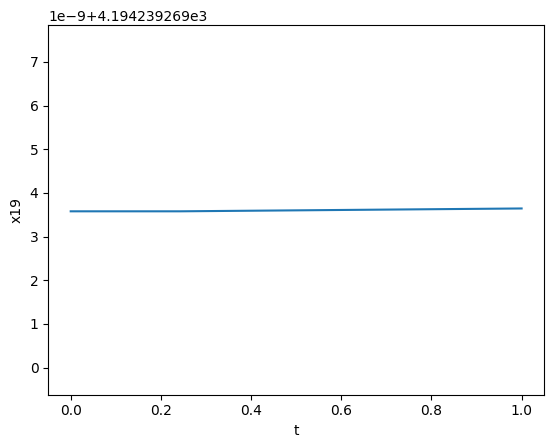

In [126]:
plt.plot(t,us.T[:,N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x{}'.format(N-1))
plt.show()

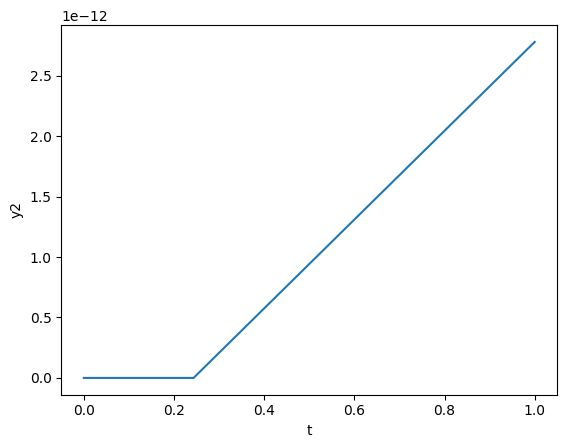

In [127]:
plt.plot(t,us.T[:,2*N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

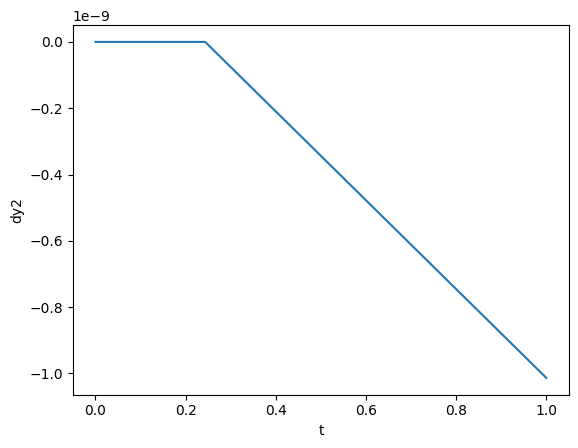

In [128]:
plt.plot(t,us.T[:,3*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

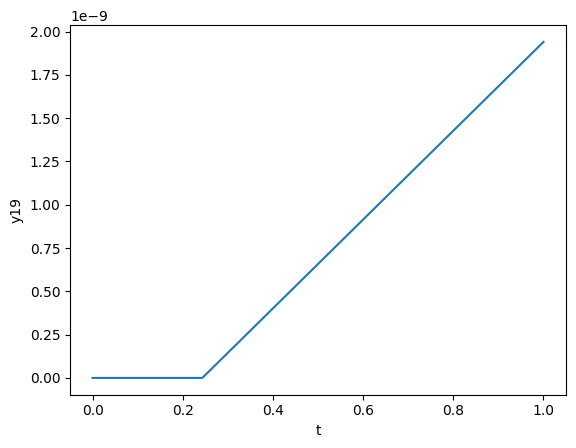

In [129]:
plt.plot(t,us.T[:,2*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('y{}'.format(N-1))
plt.show()

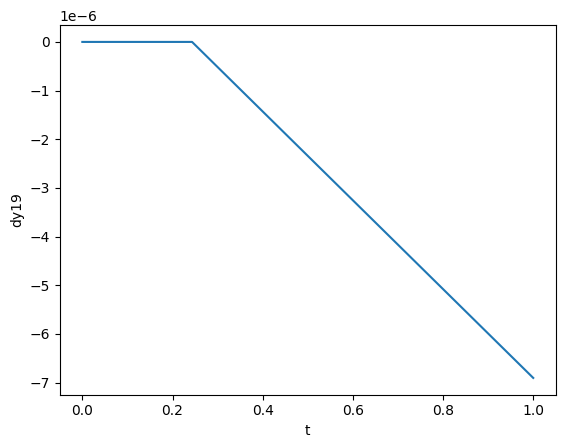

In [130]:
plt.plot(t,us.T[:,3*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('dy{}'.format(N-1))
plt.show()

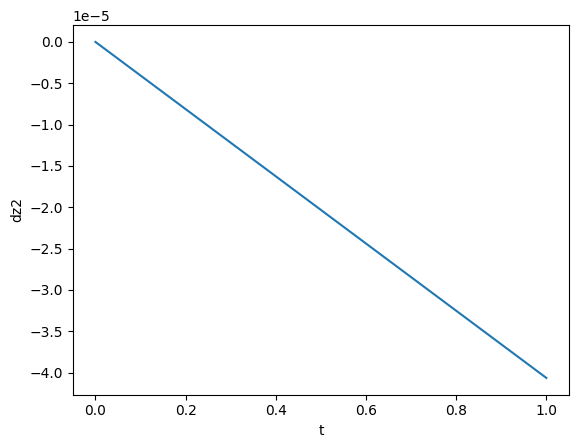

In [131]:
plt.plot(t,us.T[:,5*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

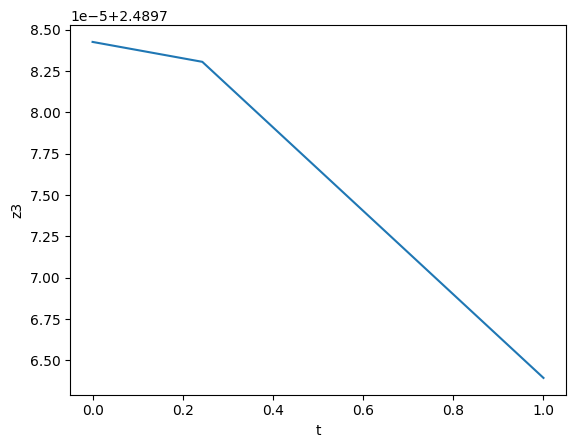

In [132]:
plt.plot(t,us.T[:,4*N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

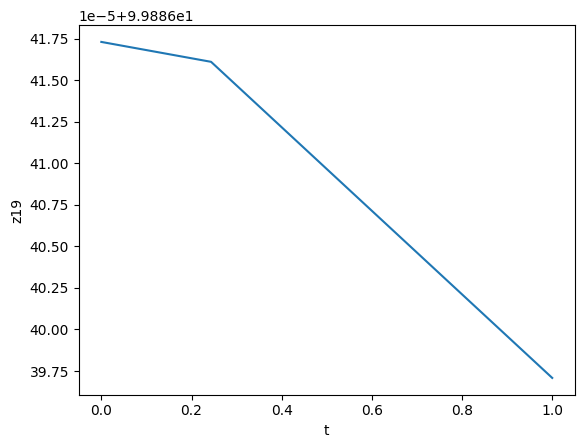

In [133]:
plt.plot(t,us.T[:,4*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('z{}'.format(N-1))
plt.show()

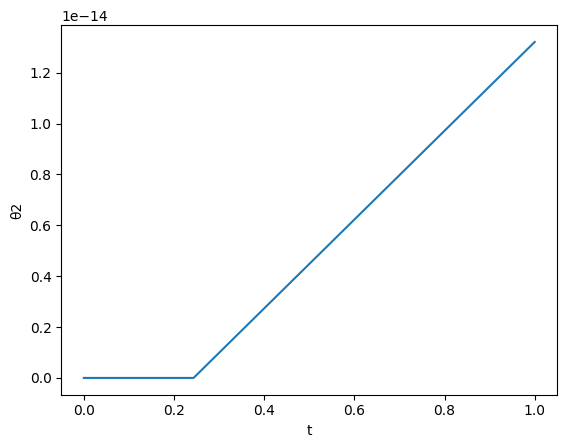

In [134]:
plt.plot(t,us.T[:,8*N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

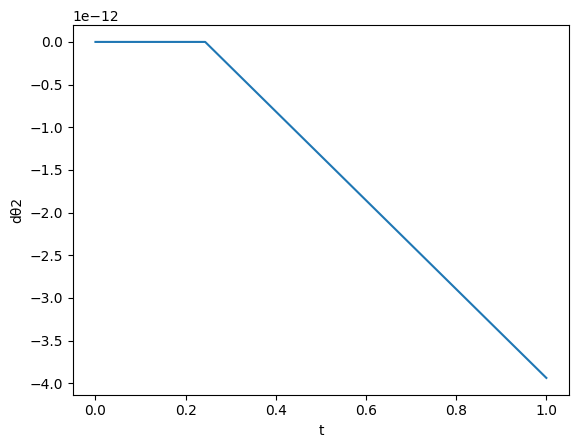

In [135]:
plt.plot(t,us.T[:,9*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

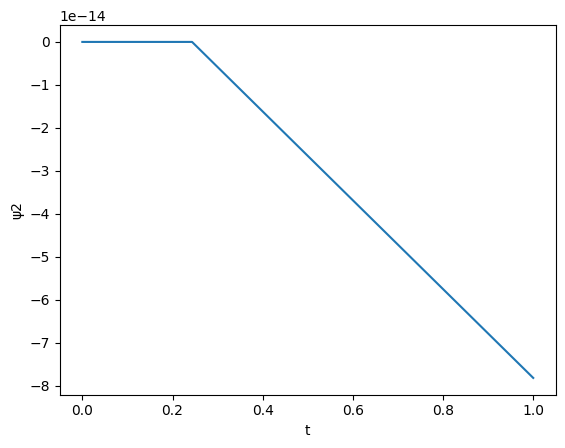

In [136]:
plt.plot(t,us.T[:,10*N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

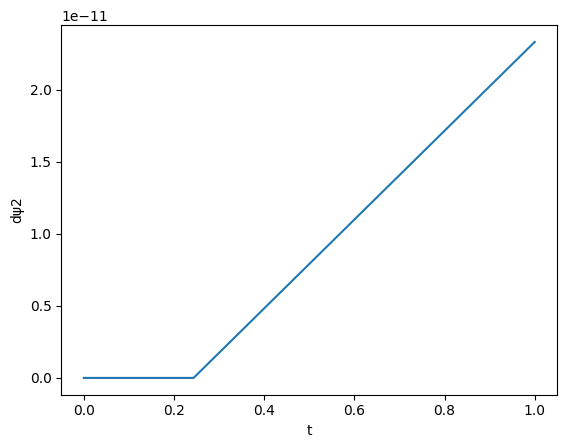

In [137]:
plt.plot(t,us.T[:,11*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

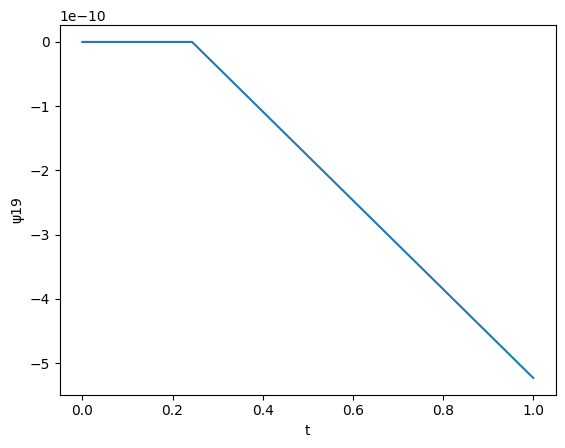

In [138]:
plt.plot(t,us.T[:,10*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('ψ{}'.format(N-1))
plt.show()